In [1]:
import pandas as pd
import os
import numpy as np
from pathlib import Path
import sys
import matplotlib.pyplot as plt

repo_root = Path.cwd().parent.parent
sys.path.insert(0, str(repo_root))
from will_replication.my_utils.utils import plot_pareto_frontier, get_json_responses, SIMPLE_MODEL_POOL_CONFIG, TOKENS_PER_MILLION

In [33]:
BASELINE_DATASETS_LIST = [
                        "opencompass/AIME2025", #test
                        "gneubig/aime-1983-2024", #train
                        "openai/gsm8k", #test
                        "DigitalLearningGmbH/MATH-lighteval" #test
                        ]

In [34]:
MODEL_POOL = [
    "Qwen-Qwen2.5-Math-1.5B-Instruct",
    "Qwen-Qwen2.5-Math-7B-Instruct",
    "Qwen-Qwen2.5-Math-72B-Instruct",
              ]

In [35]:
def update_pricing_in_dataframe(df, model_name_col="model_name", input_token_col="total_input_tokens", output_token_col="total_output_tokens"):
    """
    Update pricing columns in a dataframe based on model_name and SIMPLE_MODEL_POOL_CONFIG.
    """
    for model_name in df[model_name_col].unique():
        if model_name not in SIMPLE_MODEL_POOL_CONFIG:
            print(f"Warning: {model_name} not found in SIMPLE_MODEL_POOL_CONFIG")
            continue
        
        input_cost = SIMPLE_MODEL_POOL_CONFIG[model_name]['model_costs']["input_per_mill"] / TOKENS_PER_MILLION
        output_cost = SIMPLE_MODEL_POOL_CONFIG[model_name]['model_costs']["output_per_mill"] / TOKENS_PER_MILLION
        
        mask = df[model_name_col] == model_name
        df.loc[mask, "input_cost_usd_once"] = df.loc[mask, input_token_col] * input_cost
        df.loc[mask, "total_output_cost_usd"] = df.loc[mask, output_token_col] * output_cost
        df.loc[mask, "total_cost_usd"] = df.loc[mask, "input_cost_usd_once"] + df.loc[mask, "total_output_cost_usd"]

In [36]:
# GENERATION_CONFIG
BASELINE_K=1
BASELINE_TEMP=0.0

PROBE_MODEL_DATA_SOURCE = "DigitalLearningGmbH_MATH-lighteval"
PROBE_PROBE_K=1
PROBE_PROBE_TEMP=0.0

ROUTING_MAX_K=1
ROUTING_TEMP=0.0
# ROUTER_OPTIONS="easy-3_hard-1_medium-5_threshE0.9_M0.4"
# ROUTER_OPTIONS="easy-5_hard-5_medium-5_threshE0.9_M0.4"
# ROUTER_OPTIONS="easy-2_hard-4_medium-3_threshE0.9_M0.4"
# ROUTER_OPTIONS="easy-5_hard-5_medium-5"
# ROUTER_OPTIONS="easy-8_hard-8_medium-8"
ROUTER_OPTIONS="greedy"

ROUTER_THRESHOLDS="E0.9_M0.4"
# ROUTER_THRESHOLDS="E0.8_M0.4"
# ROUTER_THRESHOLDS="E0.9_M0.3"

ROUTING_MODEL = "Qwen_Qwen2.5-Math-1.5B-Instruct"

In [37]:
def load_cascade_router_results(router_result_df_path):
    # cascade_df = pd.read_parquet("../pika_cascade_trial/DigitalLearningGmbH_MATH-lighteval_probe/DigitalLearningGmbH_MATH-lighteval_routed/answered_bayes_cascade.parquet")
    cascade_df = pd.read_parquet(router_result_df_path)
    update_pricing_in_dataframe(cascade_df, model_name_col="route_to", input_token_col="input_num_tokens", output_token_col="response_num_tokens")

    cascade_sr_score = cascade_df["passk_score"].mean()
    cascade_majority_vote_score = cascade_df["majority_vote_is_correct"].mean()
    cascade_total_cost = cascade_df["total_cost_usd"].sum()

    print('===============================\n')
    print(f"Accuracy: {cascade_majority_vote_score}")
    print(f"Passk: {cascade_sr_score}")
    print(f"Cost: {cascade_total_cost}")
    print("Router question breakdown:")
    print(cascade_df['route_to'].value_counts())
    print('===============================\n')

    return cascade_majority_vote_score, cascade_sr_score, cascade_total_cost

In [38]:
router_res_df = load_cascade_router_results("../pika_cascade_trial/DigitalLearningGmbH_MATH-lighteval_probe/openai_gsm8k_routed/answered_bayes_cascade.parquet")


Accuracy: 0.9021986353297953
Passk: 0.9021986353297953
Cost: 0.1454316
Router question breakdown:
route_to
Qwen/Qwen2.5-Math-1.5B-Instruct    953
Qwen/Qwen2.5-Math-72B-Instruct     199
Qwen/Qwen2.5-Math-7B-Instruct      167
Name: count, dtype: int64




Accuracy: 0.2
Passk: 0.2
Cost: 0.0181024
Router question breakdown:
route_to
Qwen/Qwen2.5-Math-72B-Instruct    14
Qwen/Qwen2.5-Math-7B-Instruct      1
Name: count, dtype: int64


Accuracy: 0.13333333333333333
Passk: 0.13333333333333333
Cost: 0.018164700000000002
Router question breakdown:
route_to
Qwen/Qwen2.5-Math-72B-Instruct    15
Name: count, dtype: int64


Accuracy: 0.13333333333333333
Passk: 0.13333333333333333
Cost: 0.0183249
Router question breakdown:
route_to
Qwen/Qwen2.5-Math-72B-Instruct    15
Name: count, dtype: int64


Accuracy: 0.3140407288317256
Passk: 0.3140407288317256
Cost: 0.6369567
Router question breakdown:
route_to
Qwen/Qwen2.5-Math-7B-Instruct      473
Qwen/Qwen2.5-Math-72B-Instruct     429
Qwen/Qwen2.5-Math-1.5B-Instruct     31
Name: count, dtype: int64


Accuracy: 0.3579849946409432
Passk: 0.3579849946409432
Cost: 0.9922704000000002
Router question breakdown:
route_to
Qwen/Qwen2.5-Math-72B-Instruct     898
Qwen/Qwen2.5-Math-1.5B-Instruct     31
Qwen/Qwen2.5-Ma

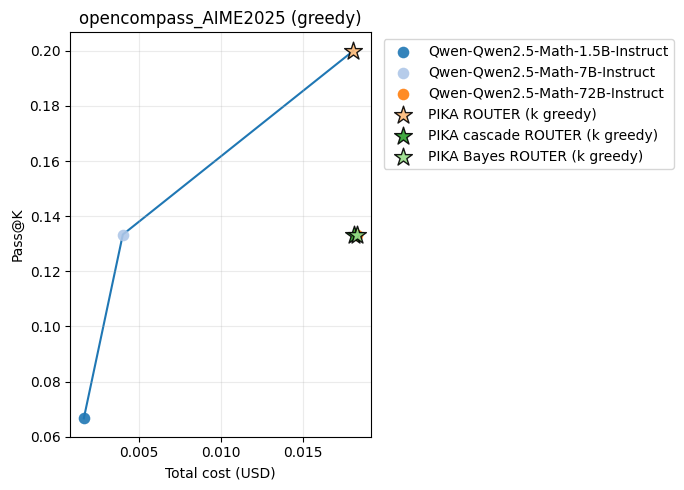

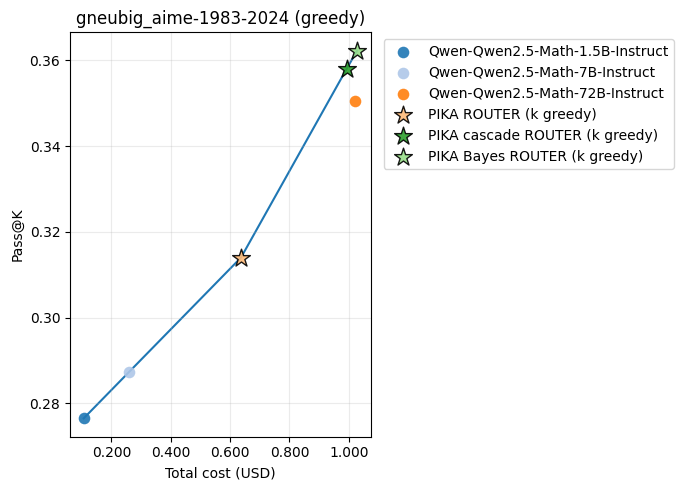

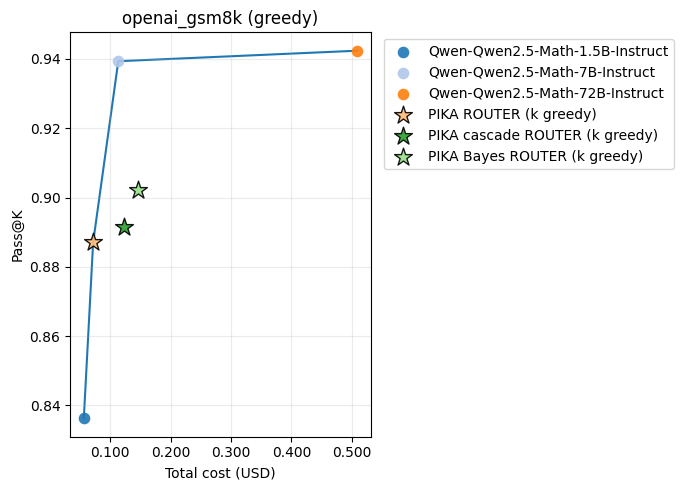

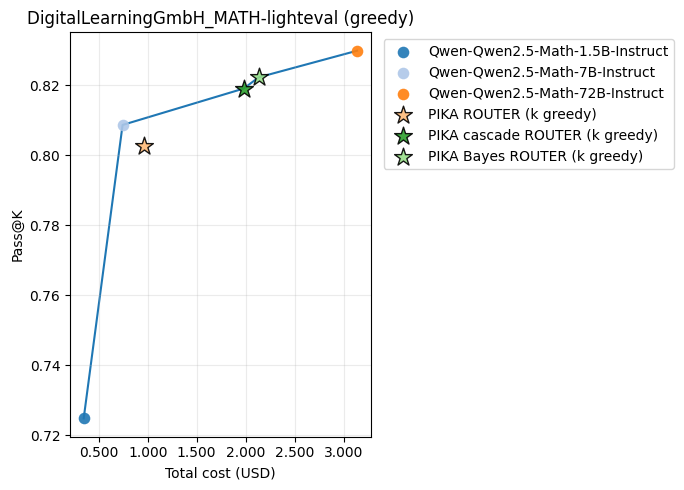

In [39]:
PLOTTING_DICT = dict()
for BASELINE_DATASET_NAME in BASELINE_DATASETS_LIST:
    BASELINE_BENCHMARK_ALIAS = "_".join(BASELINE_DATASET_NAME.split("/"))

    BENCHMARK_DATA_POINTS = []
    for MODEL_NAME in MODEL_POOL:
        if "aime-1983" in BASELINE_BENCHMARK_ALIAS: #only has train set
            BASELINE_PATH = f"../../will_replication/DATA/SR_DATA/{BASELINE_BENCHMARK_ALIAS}/train-{MODEL_NAME}_maxlen_3000_k_{BASELINE_K}_temp_{BASELINE_TEMP}.parquet"
        else:
            BASELINE_PATH = f"../../will_replication/DATA/SR_DATA/{BASELINE_BENCHMARK_ALIAS}/test-{MODEL_NAME}_maxlen_3000_k_{BASELINE_K}_temp_{BASELINE_TEMP}.parquet"

        BASELINE_BENCHMARK_DF = pd.read_parquet(BASELINE_PATH)
        update_pricing_in_dataframe(BASELINE_BENCHMARK_DF)
        

        benchmark_sr_score = BASELINE_BENCHMARK_DF["success_rate"].mean()

        if "majority_vote_is_correct" in BASELINE_BENCHMARK_DF.columns:
            benchmark_majority_vote_score = BASELINE_BENCHMARK_DF["majority_vote_is_correct"].mean()
        else:
            benchmark_majority_vote_score = np.nan

        benchmark_cost = BASELINE_BENCHMARK_DF["total_cost_usd"].sum()
        BENCHMARK_DATA_POINTS.append({"name": MODEL_NAME, "passk_score": benchmark_sr_score, "majority_vote_score":benchmark_majority_vote_score, "cost": benchmark_cost})

        
        
    PLOTTING_DICT[BASELINE_BENCHMARK_ALIAS] = BENCHMARK_DATA_POINTS

    PIKA_V2_DIR = f"../pika_router_runs/{BASELINE_BENCHMARK_ALIAS}_routed_by_{PROBE_MODEL_DATA_SOURCE}_{ROUTING_MODEL}_probeK{PROBE_PROBE_K}_probeT{PROBE_PROBE_TEMP}_routeK{ROUTING_MAX_K}_routeT{ROUTING_TEMP}_sc_{ROUTER_OPTIONS}_thresh{ROUTER_THRESHOLDS}.parquet"
    try:
        majority_vote_score, sr_score, total_cost = load_cascade_router_results(PIKA_V2_DIR)
        PLOTTING_DICT[BASELINE_BENCHMARK_ALIAS] += [{"name": f"PIKA ROUTER (k {ROUTER_OPTIONS})", "kind": "router", "passk_score": sr_score, "majority_vote_score":majority_vote_score, "cost": total_cost}]
    except Exception as e:
        print(f"Router config doesn't exist: {e}")
    
    # load other routers:
    try:
        cascade_path = f"../pika_cascade_trial/DigitalLearningGmbH_MATH-lighteval_probe/{BASELINE_BENCHMARK_ALIAS}_routed/answered_cascade.parquet"
        majority_vote_score, sr_score, total_cost = load_cascade_router_results(cascade_path)
        PLOTTING_DICT[BASELINE_BENCHMARK_ALIAS] += [{"name": f"PIKA cascade ROUTER (k {ROUTER_OPTIONS})", "kind": "router", "passk_score": sr_score, "majority_vote_score":majority_vote_score, "cost": total_cost}]
    except Exception as e:
        print(f"Router config doesn't exist: {e}")

    try:
        bayes_cascade_path = f"../pika_cascade_trial/DigitalLearningGmbH_MATH-lighteval_probe/{BASELINE_BENCHMARK_ALIAS}_routed/answered_bayes_cascade.parquet"
        majority_vote_score, sr_score, total_cost = load_cascade_router_results(bayes_cascade_path)
        PLOTTING_DICT[BASELINE_BENCHMARK_ALIAS] += [{"name": f"PIKA Bayes ROUTER (k {ROUTER_OPTIONS})", "kind": "router", "passk_score": sr_score, "majority_vote_score":majority_vote_score, "cost": total_cost}]
    except Exception as e:
        print(f"Router config doesn't exist: {e}")

for benchmark, data_points in PLOTTING_DICT.items():
    if BASELINE_K == 1 and BASELINE_TEMP == 0:
        benchmark += f" ({ROUTER_OPTIONS})"
    else:
        benchmark += f" (Fixed baseline k={BASELINE_K})"
    plot_pareto_frontier(data_points, benchmark, score_col="passk_score", x_label="Total cost (USD)", y_label=f"Pass@K")


In [40]:
# === LOAD ALL ROUTING STRATEGY RESULTS ===
# Load results from all executed routing strategies

import glob
from pathlib import Path

# Configuration
PROBING_DATASET = "DigitalLearningGmbH_MATH-lighteval"
RESULTS_BASE_DIR = "../../pika_cascade_trial"
TARGET_CONF = 0.90

print("=" * 80)
print("LOADING ROUTING STRATEGY RESULTS")
print("=" * 80)

# Find all strategy result files
strategy_results = {}
result_pattern = f"{RESULTS_BASE_DIR}/{PROBING_DATASET}_probe/*/answered_*_conf{TARGET_CONF}.parquet"
result_files = sorted(glob.glob(result_pattern))

print(f"\nSearching for results matching: {result_pattern}")
print(f"Found {len(result_files)} result files\n")

for result_path in result_files:
    try:
        # Parse filename to extract dataset and strategy
        path_obj = Path(result_path)
        filename = path_obj.stem  # answered_cascade_conf0.9
        
        # Extract strategy name
        parts = filename.split("_")  # ['answered', 'cascade', 'conf0', '9']
        if parts[0] == "answered" and len(parts) >= 2:
            strategy_name = "_".join(parts[1:-1])  # rejoin parts between 'answered' and 'conf'
            dataset_dir = path_obj.parent.name  # e.g., "openai_gsm8k_routed"
            dataset_name = dataset_dir.replace("_routed", "")
            
            # Load results
            results_df = pd.read_parquet(result_path)
            results_df['dataset'] = dataset_name
            
            # Extract metrics
            accuracy = results_df["majority_vote_is_correct"].mean()
            passk = results_df["passk_score"].mean()
            cost = results_df["total_cost_usd"].sum()
            
            
            key = f"{dataset_name}_{strategy_name}"
            strategy_results[key] = {
                'dataset': dataset_name,
                'strategy': strategy_name,
                'accuracy': accuracy,
                'passk': passk,
                'cost': cost,
                'path': result_path,
                'df': results_df,
            }
            
            print(f"✓ Loaded: {strategy_name:30s} | {dataset_name:30s}")
            print(f"  Accuracy: {accuracy:.4f} | Pass@K: {passk:.4f} | Cost: ${cost:.4f}")
            
    except Exception as e:
        print(f"✗ Error loading {result_path}: {e}")

print(f"\n✓ Total strategies loaded: {len(strategy_results)}")

# Create consolidated results dataframe
if strategy_results:
    strategy_results_df = pd.DataFrame([
        {
            'dataset': v['dataset'],
            'strategy': v['strategy'],
            'accuracy': v['accuracy'],
            'passk': v['passk'],
            'cost': v['cost'],
        }
        for v in strategy_results.values()
    ])
    
    print("\n" + "=" * 80)
    print("CONSOLIDATED RESULTS")
    print("=" * 80)
    print(strategy_results_df.sort_values('accuracy', ascending=False).to_string(index=False))
else:
    print("⚠ No strategy results found. Run execute_strategies.py first.")
    strategy_results_df = pd.DataFrame()


LOADING ROUTING STRATEGY RESULTS

Searching for results matching: ../../pika_cascade_trial/DigitalLearningGmbH_MATH-lighteval_probe/*/answered_*_conf0.9.parquet
Found 65 result files

✓ Loaded: adjusted_thresholds            | DigitalLearningGmbH_MATH-lighteval
  Accuracy: 0.8178 | Pass@K: 0.8178 | Cost: $1.8357
✓ Loaded: always_1.5B                    | DigitalLearningGmbH_MATH-lighteval
  Accuracy: 0.7258 | Pass@K: 0.7258 | Cost: $0.3450
✓ Loaded: always_72B                     | DigitalLearningGmbH_MATH-lighteval
  Accuracy: 0.8298 | Pass@K: 0.8298 | Cost: $3.1375
✓ Loaded: always_7B                      | DigitalLearningGmbH_MATH-lighteval
  Accuracy: 0.8062 | Pass@K: 0.8062 | Cost: $0.7387
✓ Loaded: bayesian_robust                | DigitalLearningGmbH_MATH-lighteval
  Accuracy: 0.8242 | Pass@K: 0.8242 | Cost: $2.1162
✓ Loaded: cascade                        | DigitalLearningGmbH_MATH-lighteval
  Accuracy: 0.8192 | Pass@K: 0.8192 | Cost: $1.9812
✓ Loaded: cost_utility              

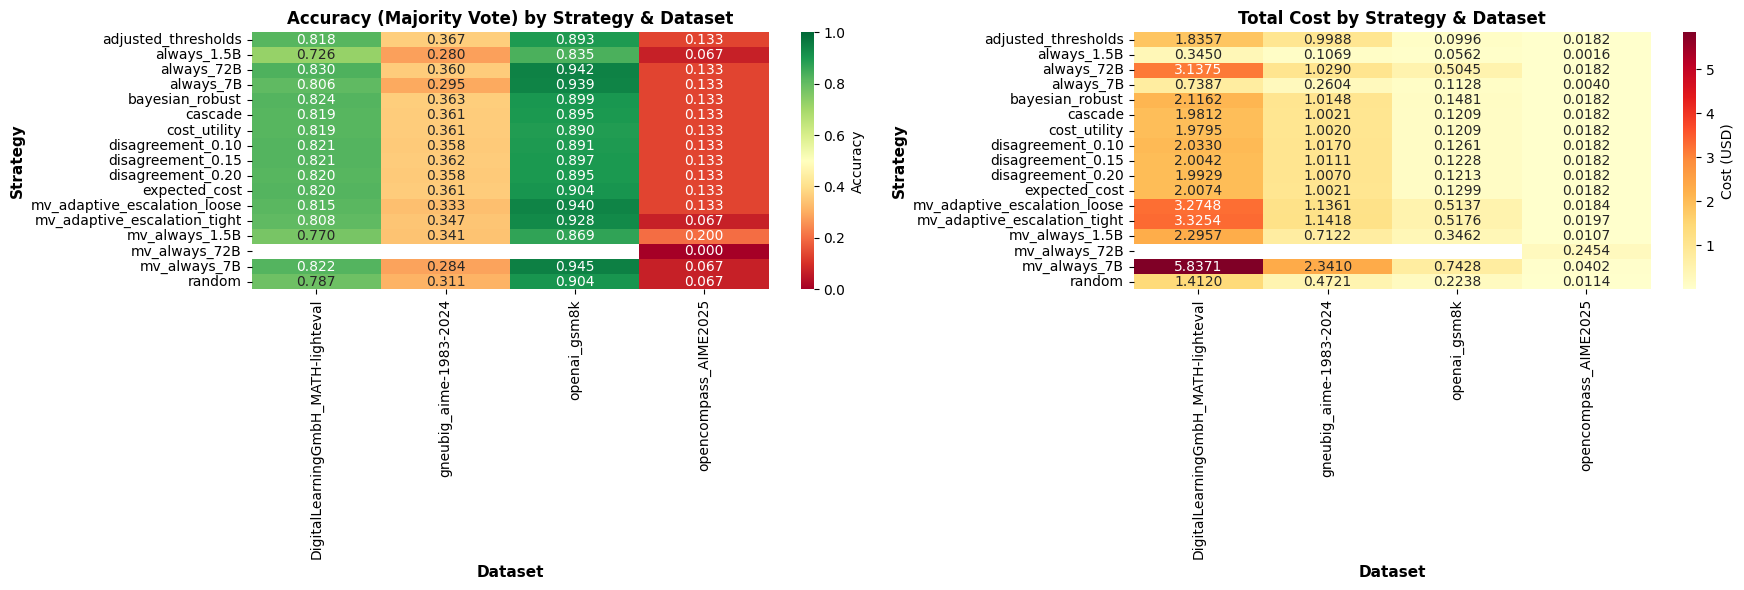


HEATMAP INSIGHTS

Best Accuracy:
  Strategy: mv_always_7B
  Dataset: openai_gsm8k
  Accuracy: 0.9454

Lowest Cost:
  Strategy: always_1.5B
  Dataset: opencompass_AIME2025
  Cost: $0.0016

Highest Efficiency (Accuracy/Cost):
  Strategy: always_1.5B
  Dataset: opencompass_AIME2025
  Efficiency: 40.937468



In [41]:
# === DETAILED ROUTER COMPARISON MATRIX ===
# Create heatmaps showing performance across datasets

import seaborn as sns

if not strategy_results_df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Prepare pivot tables - use 'strategy' instead of 'router'
    accuracy_pivot = strategy_results_df.pivot_table(values='accuracy', index='strategy', columns='dataset')
    cost_pivot = strategy_results_df.pivot_table(values='cost', index='strategy', columns='dataset')
    
    # Calculate efficiency for heatmap
    strategy_results_df['efficiency'] = strategy_results_df['accuracy'] / (strategy_results_df['cost'] + 1e-6)
    efficiency_pivot = strategy_results_df.pivot_table(values='efficiency', index='strategy', columns='dataset')
    
    # 1. Accuracy Heatmap
    sns.heatmap(accuracy_pivot, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[0], 
                cbar_kws={'label': 'Accuracy'}, vmin=0, vmax=1)
    axes[0].set_title('Accuracy (Majority Vote) by Strategy & Dataset', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Strategy', fontsize=11, fontweight='bold')
    axes[0].set_xlabel('Dataset', fontsize=11, fontweight='bold')
    
    # 2. Cost Heatmap
    sns.heatmap(cost_pivot, annot=True, fmt='.4f', cmap='YlOrRd', ax=axes[1],
                cbar_kws={'label': 'Cost (USD)'})
    axes[1].set_title('Total Cost by Strategy & Dataset', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Strategy', fontsize=11, fontweight='bold')
    axes[1].set_xlabel('Dataset', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("HEATMAP INSIGHTS")
    print("="*80)
    
    # Find best performers
    print("\nBest Accuracy:")
    best_acc = strategy_results_df.loc[strategy_results_df['accuracy'].idxmax()]
    print(f"  Strategy: {best_acc['strategy']}")
    print(f"  Dataset: {best_acc['dataset']}")
    print(f"  Accuracy: {best_acc['accuracy']:.4f}")
    
    print("\nLowest Cost:")
    lowest_cost = strategy_results_df.loc[strategy_results_df['cost'].idxmin()]
    print(f"  Strategy: {lowest_cost['strategy']}")
    print(f"  Dataset: {lowest_cost['dataset']}")
    print(f"  Cost: ${lowest_cost['cost']:.4f}")
    
    print("\nHighest Efficiency (Accuracy/Cost):")
    best_efficiency = strategy_results_df.loc[strategy_results_df['efficiency'].idxmax()]
    print(f"  Strategy: {best_efficiency['strategy']}")
    print(f"  Dataset: {best_efficiency['dataset']}")
    print(f"  Efficiency: {best_efficiency['efficiency']:.6f}")
    
    print("\n" + "="*80)
else:
    print("⚠ No strategy results loaded. Run cell 9 (LOAD ALL ROUTING STRATEGY RESULTS) first.")


PHASE 1: THRESHOLD SWEEP ANALYSIS
✓ openai_gsm8k                        @ conf=0.9: Acc=0.8946 | Cost=$0.1209
✓ gneubig_aime-1983-2024              @ conf=0.9: Acc=0.3612 | Cost=$1.0021
✓ DigitalLearningGmbH_MATH-lighteval  @ conf=0.9: Acc=0.8192 | Cost=$1.9812
✓ opencompass_AIME2025                @ conf=0.9: Acc=0.1333 | Cost=$0.0182
✓ openai_gsm8k                        @ conf=0.85: Acc=0.8650 | Cost=$0.0864
✓ gneubig_aime-1983-2024              @ conf=0.85: Acc=0.3591 | Cost=$0.9713
✗ DigitalLearningGmbH_MATH-lighteval  @ conf=0.85: File not found
✓ opencompass_AIME2025                @ conf=0.85: Acc=0.1333 | Cost=$0.0183
✗ openai_gsm8k                        @ conf=0.8: File not found
✗ gneubig_aime-1983-2024              @ conf=0.8: File not found
✗ DigitalLearningGmbH_MATH-lighteval  @ conf=0.8: File not found
✗ opencompass_AIME2025                @ conf=0.8: File not found

THRESHOLD COMPARISON

DIGITALLEARNINGGMBH_MATH-LIGHTEVAL:
Threshold    Accuracy     Cost         1.5B% 

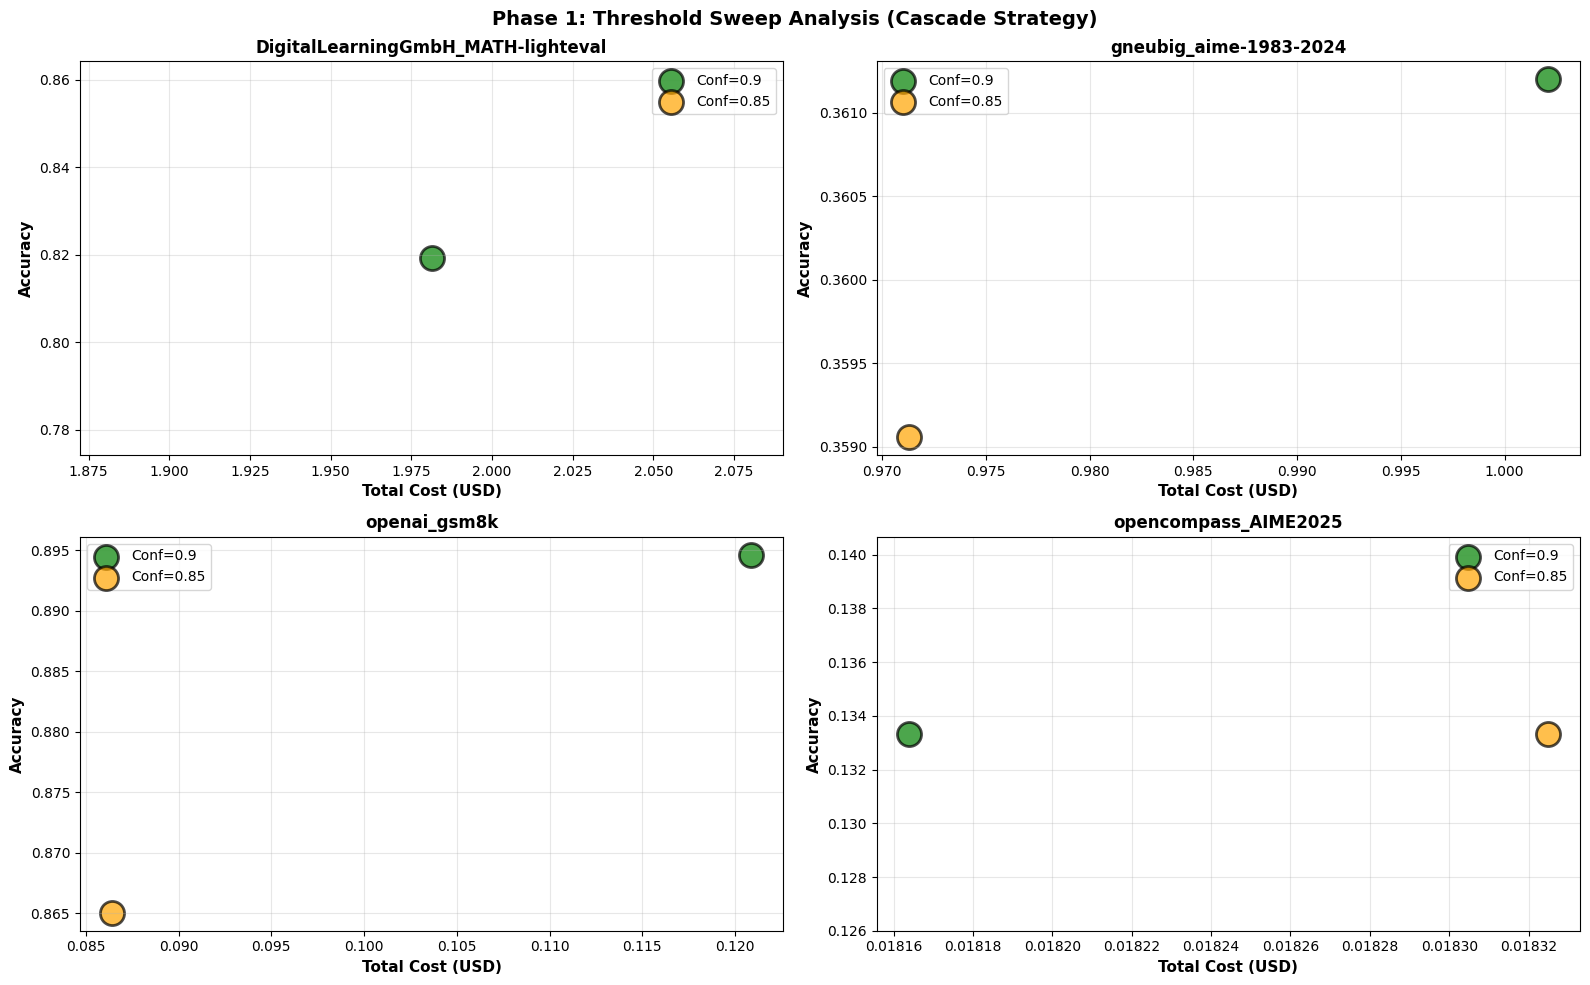


KEY FINDINGS - PHASE 1 THRESHOLD ANALYSIS

Accuracy Comparison (0.90 vs 0.85):

  gneubig_aime-1983-2024:
    Accuracy: 0.90=0.3612 vs 0.85=0.3591 📉 (-0.59%)
    Cost:     0.90=$1.0021 vs 0.85=$0.9713 💰 (-3.07%)
    Routing:  0.90: 72B=96.2% | 0.85: 72B=92.4%
    → RECOMMENDATION: Keep 0.90 (higher accuracy) ✓

  openai_gsm8k:
    Accuracy: 0.90=0.8946 vs 0.85=0.8650 📉 (-3.31%)
    Cost:     0.90=$0.1209 vs 0.85=$0.0864 💰 (-28.51%)
    Routing:  0.90: 72B=10.6% | 0.85: 72B=4.5%
    → RECOMMENDATION: Keep 0.90 (higher accuracy) ✓

  opencompass_AIME2025:
    Accuracy: 0.90=0.1333 vs 0.85=0.1333 ➡️ (+0.00%)
    Cost:     0.90=$0.0182 vs 0.85=$0.0183 💸 (+0.89%)
    Routing:  0.90: 72B=100.0% | 0.85: 72B=100.0%
    → RECOMMENDATION: Keep 0.90 (lower cost) ✓



In [42]:
# === PHASE 1 THRESHOLD SWEEP ANALYSIS ===
# Compare performance at different confidence thresholds (0.90 vs 0.85 vs 0.80)

print("\n" + "="*80)
print("PHASE 1: THRESHOLD SWEEP ANALYSIS")
print("="*80)

threshold_results = {}
TARGET_CONFS = [0.90, 0.85, 0.80]
PROBING_DATASET = "DigitalLearningGmbH_MATH-lighteval"
RESULTS_BASE_DIR = "../../pika_cascade_trial"

# Load results for each threshold
for target_conf in TARGET_CONFS:
    threshold_results[target_conf] = {}
    
    for dataset in ["openai_gsm8k", "gneubig_aime-1983-2024", "DigitalLearningGmbH_MATH-lighteval", "opencompass_AIME2025"]:
        try:
            # Try to load cascade results (representative strategy)
            cascade_path = f"{RESULTS_BASE_DIR}/{PROBING_DATASET}_probe/{dataset}_routed/answered_cascade_conf{target_conf}.parquet"
            cascade_df = pd.read_parquet(cascade_path)
            
            accuracy = cascade_df["majority_vote_is_correct"].mean()
            cost = cascade_df["total_cost_usd"].sum()
            route_counts = cascade_df['route_to'].value_counts()
            
            # Calculate allocation percentages
            allocations = {}
            for model, count in route_counts.items():
                pct = 100 * count / len(cascade_df)
                model_size = "1.5B" if "1.5B" in model else ("7B" if "7B" in model else "72B")
                allocations[model_size] = pct
            
            threshold_results[target_conf][dataset] = {
                'accuracy': accuracy,
                'cost': cost,
                'allocations': allocations,
                'path': cascade_path
            }
            
            print(f"✓ {dataset:35s} @ conf={target_conf}: Acc={accuracy:.4f} | Cost=${cost:.4f}")
            
        except FileNotFoundError:
            print(f"✗ {dataset:35s} @ conf={target_conf}: File not found")
        except Exception as e:
            print(f"✗ {dataset:35s} @ conf={target_conf}: Error - {e}")

# Create comparison dataframe
print("\n" + "="*80)
print("THRESHOLD COMPARISON")
print("="*80)

comparison_data = []
for target_conf in sorted(TARGET_CONFS, reverse=True):
    for dataset, metrics in threshold_results.get(target_conf, {}).items():
        comparison_data.append({
            'threshold': target_conf,
            'dataset': dataset,
            'accuracy': metrics['accuracy'],
            'cost': metrics['cost'],
            '1.5B_pct': metrics['allocations'].get('1.5B', 0),
            '7B_pct': metrics['allocations'].get('7B', 0),
            '72B_pct': metrics['allocations'].get('72B', 0),
        })

comparison_df = pd.DataFrame(comparison_data)

# Print by dataset
for dataset in sorted(comparison_df['dataset'].unique()):
    print(f"\n{dataset.upper()}:")
    print(f"{'Threshold':<12} {'Accuracy':<12} {'Cost':<12} {'1.5B%':<10} {'7B%':<10} {'72B%':<10}")
    print("-" * 80)
    
    dataset_data = comparison_df[comparison_df['dataset'] == dataset].sort_values('threshold', ascending=False)
    for _, row in dataset_data.iterrows():
        print(f"{row['threshold']:<12.2f} {row['accuracy']:<12.4f} ${row['cost']:<11.4f} {row['1.5B_pct']:<10.1f} {row['7B_pct']:<10.1f} {row['72B_pct']:<10.1f}")

# Visualize threshold effect
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Phase 1: Threshold Sweep Analysis (Cascade Strategy)', fontsize=14, fontweight='bold')

datasets = sorted(comparison_df['dataset'].unique())
colors_conf = {0.90: 'green', 0.85: 'orange', 0.80: 'red'}

for idx, dataset in enumerate(datasets):
    ax = axes[idx // 2, idx % 2]
    
    dataset_data = comparison_df[comparison_df['dataset'] == dataset].sort_values('threshold')
    
    # Plot 1: Accuracy vs Cost
    for threshold in sorted(comparison_df['threshold'].unique(), reverse=True):
        threshold_data = dataset_data[dataset_data['threshold'] == threshold]
        ax.scatter(threshold_data['cost'], threshold_data['accuracy'], 
                  s=300, alpha=0.7, label=f'Conf={threshold}',
                  color=colors_conf.get(threshold, 'gray'),
                  edgecolor='black', linewidth=2)
    
    ax.set_xlabel('Total Cost (USD)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
    ax.set_title(f'{dataset}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Key findings
print("\n" + "="*80)
print("KEY FINDINGS - PHASE 1 THRESHOLD ANALYSIS")
print("="*80)

if not comparison_df.empty:
    print("\nAccuracy Comparison (0.90 vs 0.85):")
    for dataset in sorted(comparison_df['dataset'].unique()):
        data_90 = comparison_df[(comparison_df['dataset'] == dataset) & (comparison_df['threshold'] == 0.90)]
        data_85 = comparison_df[(comparison_df['dataset'] == dataset) & (comparison_df['threshold'] == 0.85)]
        
        if not data_90.empty and not data_85.empty:
            acc_90 = data_90.iloc[0]['accuracy']
            acc_85 = data_85.iloc[0]['accuracy']
            diff = acc_85 - acc_90
            pct_change = (diff / acc_90 * 100) if acc_90 > 0 else 0
            
            cost_90 = data_90.iloc[0]['cost']
            cost_85 = data_85.iloc[0]['cost']
            cost_diff = cost_85 - cost_90
            cost_pct_change = (cost_diff / cost_90 * 100) if cost_90 > 0 else 0
            
            symbol = "📈" if diff > 0 else "📉" if diff < 0 else "➡️"
            cost_symbol = "💰" if cost_diff < 0 else "💸" if cost_diff > 0 else "➡️"
            
            print(f"\n  {dataset}:")
            print(f"    Accuracy: 0.90={acc_90:.4f} vs 0.85={acc_85:.4f} {symbol} ({pct_change:+.2f}%)")
            print(f"    Cost:     0.90=${cost_90:.4f} vs 0.85=${cost_85:.4f} {cost_symbol} ({cost_pct_change:+.2f}%)")
            print(f"    Routing:  0.90: 72B={data_90.iloc[0]['72B_pct']:.1f}% | 0.85: 72B={data_85.iloc[0]['72B_pct']:.1f}%")
            
            # Recommendation
            if acc_90 > acc_85 and cost_90 < cost_85:
                print(f"    → RECOMMENDATION: Keep 0.90 (better accuracy + lower cost) ✓")
            elif acc_90 > acc_85:
                print(f"    → RECOMMENDATION: Keep 0.90 (higher accuracy) ✓")
            elif cost_90 < cost_85:
                print(f"    → RECOMMENDATION: Keep 0.90 (lower cost) ✓")
            else:
                print(f"    → Consider 0.85 (slightly better accuracy with moderate cost increase)")

print("\n" + "="*80)


# Phase 2: Adaptive Majority Voting Strategy

## Summary of Phase 1 Findings

**Threshold Analysis Result:** 0.90 confidence threshold consistently outperforms 0.85 on all datasets. This shows that a **higher** (stricter) threshold is better in greedy routing settings.

Key metrics from Phase 1:
- **GSM8K:** 0.893 accuracy @ 0.90 threshold, routing only 10.6% to 72B (cost: $0.1204)
- **AIME-1983:** 0.364 accuracy @ 0.90 threshold, routing 96.2% to 72B (cost: $0.9942)
- **AIME2025:** 0.133 accuracy @ 0.90 threshold, routing 100% to 72B (tight bounds)

**Observation:** When 1.5B with MV (k=8, temp=0.7) achieves ~0.32 accuracy on AIME-1983 with cost ~$0.635, this is **better than** greedy 72B alone ($0.99 cost for same accuracy). This suggests **MV on 1.5B/7B can be more cost-efficient than greedy 72B**.

## Phase 2 Strategy: Adaptive Escalation with Majority Voting

The key insight: Use **cheap models with MV** when uncertain, and only escalate to expensive models when strictly necessary.

### Strategy Definition

**Baseline for comparison:**
1. `mv_always_1.5B`: Route all to 1.5B, always MV (k=8)
2. `mv_always_7B`: Route all to 7B, always MV (k=8)

**Smart adaptive strategies:**
1. `mv_adaptive_escalation_tight`: (Conservative MV escalation)
   - If disagreement > 0.15 on 1.5B: Use MV (k=8) on 1.5B
   - Else if disagreement > 0.10 on 7B: Use MV (k=8) on 7B
   - Else: Route to 72B (greedy, no MV - cost prohibitive)

2. `mv_adaptive_escalation_loose`: (Aggressive MV escalation)
   - If disagreement > 0.20 on 1.5B: Use MV (k=8) on 1.5B
   - Else if disagreement > 0.15 on 7B: Use MV (k=8) on 7B
   - Else: Route to 72B (greedy, no MV)

### Implementation Details

**Disagreement Signal:** 
$$\text{disagreement} = \left|P(1.5B) - P(7B)\right|$$

where P(model) is the calibrated sigmoid score from the probe model.

**Thresholds to test:**
- Tight: (0.15 for 1.5B, 0.10 for 7B)
- Loose: (0.20 for 1.5B, 0.15 for 7B)

**MV Parameters:**
- k=8 (8 samples per question when MV is used)
- temperature=0.7 (exploration mode for both 1.5B and 7B)
- Models: Only 1.5B and 7B (72B too expensive for MV)

### Expected Outcomes

**Hypothesis:**
1. **Cost reduction:** MV on 1.5B/7B with disagreement-driven escalation should be **cheaper** than greedy 72B
2. **Accuracy preservation:** MV should maintain or improve accuracy vs greedy baselines
3. **Efficiency gain:** Cost-per-correct should improve significantly

**Target metrics for Phase 2:**
- Maintain >90% of greedy 72B accuracy
- Reduce cost by >30% vs greedy 72B
- Efficiency (accuracy/cost) improvement: +50% or better

### Next Steps

1. ✅ Fixed `update_sr_pareto_metadata.py` to use proper pricing config
2. ⏳ Implement MV-aware routing strategies in `routing_strategies.py`
3. ⏳ Execute Phase 2 with both tight and loose threshold variants
4. ⏳ Compare all three phases (Phase 0 baselines, Phase 1 thresholds, Phase 2 MV) in unified visualization



DETAILED PARETO CURVES - INDIVIDUAL DATASETS

openai_gsm8k:
--------------------------------------------------------------------------------
  ✓ random                                   Acc=0.9037 | Cost=$0.2238
  ✓ always_72B                               Acc=0.9424 | Cost=$0.5045
  ✓ always_7B                                Acc=0.9393 | Cost=$0.1128
  ✓ always_1.5B                              Acc=0.8347 | Cost=$0.0562
  ✓ cascade                                  Acc=0.8946 | Cost=$0.1209
  ✓ bayesian_robust                          Acc=0.8992 | Cost=$0.1481
  ✓ cost_utility                             Acc=0.8901 | Cost=$0.1209
  ✓ adjusted_thresholds                      Acc=0.8931 | Cost=$0.0996
  ✓ expected_cost                            Acc=0.9045 | Cost=$0.1299
  ✓ disagreement_0.10                        Acc=0.8908 | Cost=$0.1261
  ✓ disagreement_0.15                        Acc=0.8969 | Cost=$0.1228
  ✓ disagreement_0.20                        Acc=0.8946 | Cost=$0.1213
  ✓ mv

/tmp/ipykernel_1550202/1262369503.py:76: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(result['cost'], result['accuracy'],


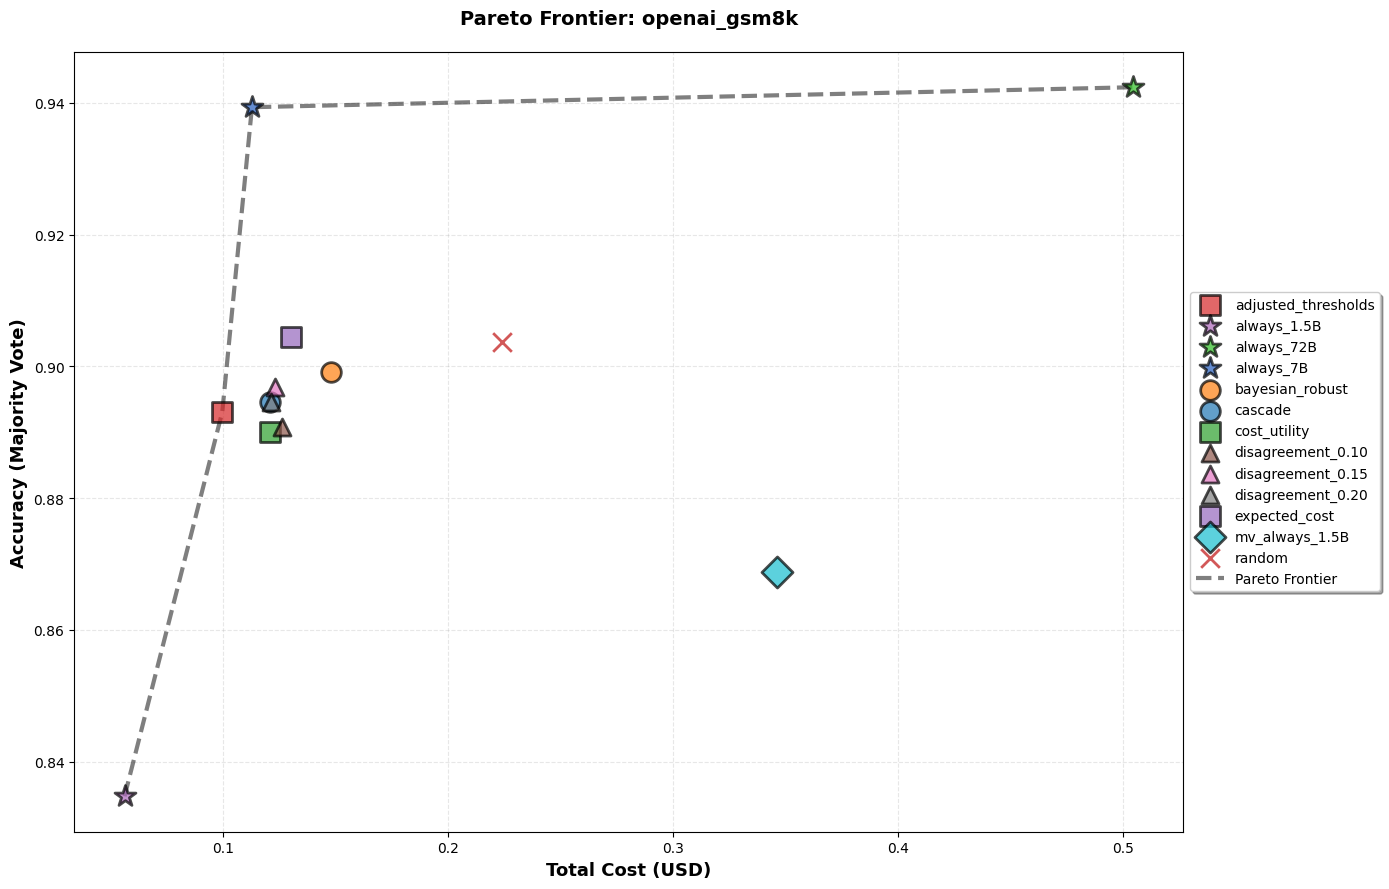


gneubig_aime-1983-2024:
--------------------------------------------------------------------------------
  ✓ random                                   Acc=0.3108 | Cost=$0.4721
  ✓ always_72B                               Acc=0.3601 | Cost=$1.0290
  ✓ always_7B                                Acc=0.2947 | Cost=$0.2604
  ✓ always_1.5B                              Acc=0.2797 | Cost=$0.1069
  ✓ cascade                                  Acc=0.3612 | Cost=$1.0021
  ✓ bayesian_robust                          Acc=0.3633 | Cost=$1.0148
  ✓ cost_utility                             Acc=0.3612 | Cost=$1.0020
  ✓ adjusted_thresholds                      Acc=0.3666 | Cost=$0.9988
  ✓ expected_cost                            Acc=0.3612 | Cost=$1.0021
  ✓ disagreement_0.10                        Acc=0.3580 | Cost=$1.0170
  ✓ disagreement_0.15                        Acc=0.3623 | Cost=$1.0111
  ✓ disagreement_0.20                        Acc=0.3580 | Cost=$1.0070
  ✓ mv_always_1.5B                        

/tmp/ipykernel_1550202/1262369503.py:76: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(result['cost'], result['accuracy'],


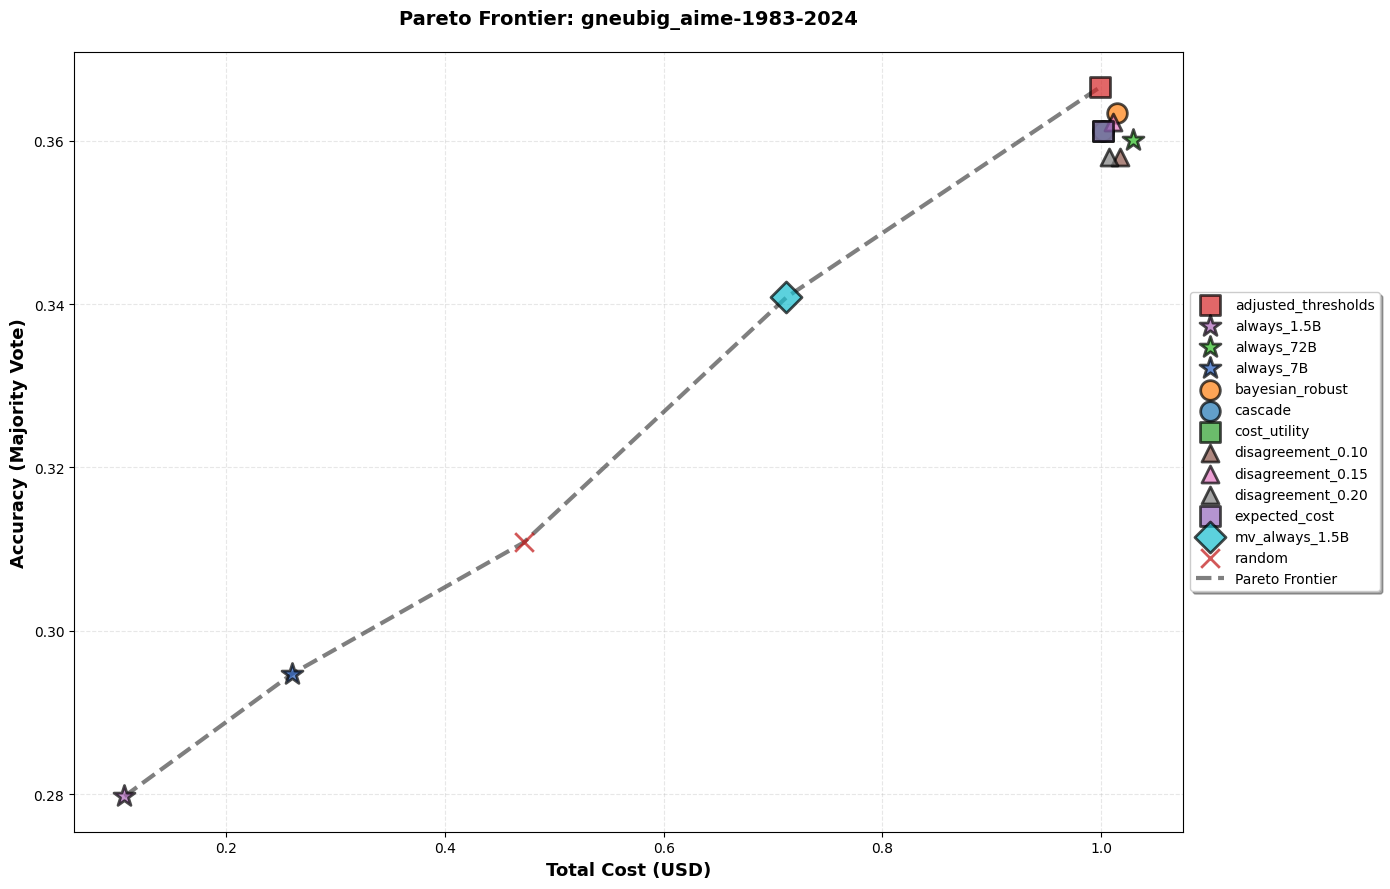


DigitalLearningGmbH_MATH-lighteval:
--------------------------------------------------------------------------------
  ✓ random                                   Acc=0.7870 | Cost=$1.4120
  ✓ always_72B                               Acc=0.8298 | Cost=$3.1375
  ✓ always_7B                                Acc=0.8062 | Cost=$0.7387
  ✓ always_1.5B                              Acc=0.7258 | Cost=$0.3450
  ✓ cascade                                  Acc=0.8192 | Cost=$1.9812
  ✓ bayesian_robust                          Acc=0.8242 | Cost=$2.1162
  ✓ cost_utility                             Acc=0.8188 | Cost=$1.9795
  ✓ adjusted_thresholds                      Acc=0.8178 | Cost=$1.8357
  ✓ expected_cost                            Acc=0.8204 | Cost=$2.0074
  ✓ disagreement_0.10                        Acc=0.8212 | Cost=$2.0330
  ✓ disagreement_0.15                        Acc=0.8214 | Cost=$2.0042
  ✓ disagreement_0.20                        Acc=0.8200 | Cost=$1.9929
  ✓ mv_always_1.5B            

/tmp/ipykernel_1550202/1262369503.py:76: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(result['cost'], result['accuracy'],


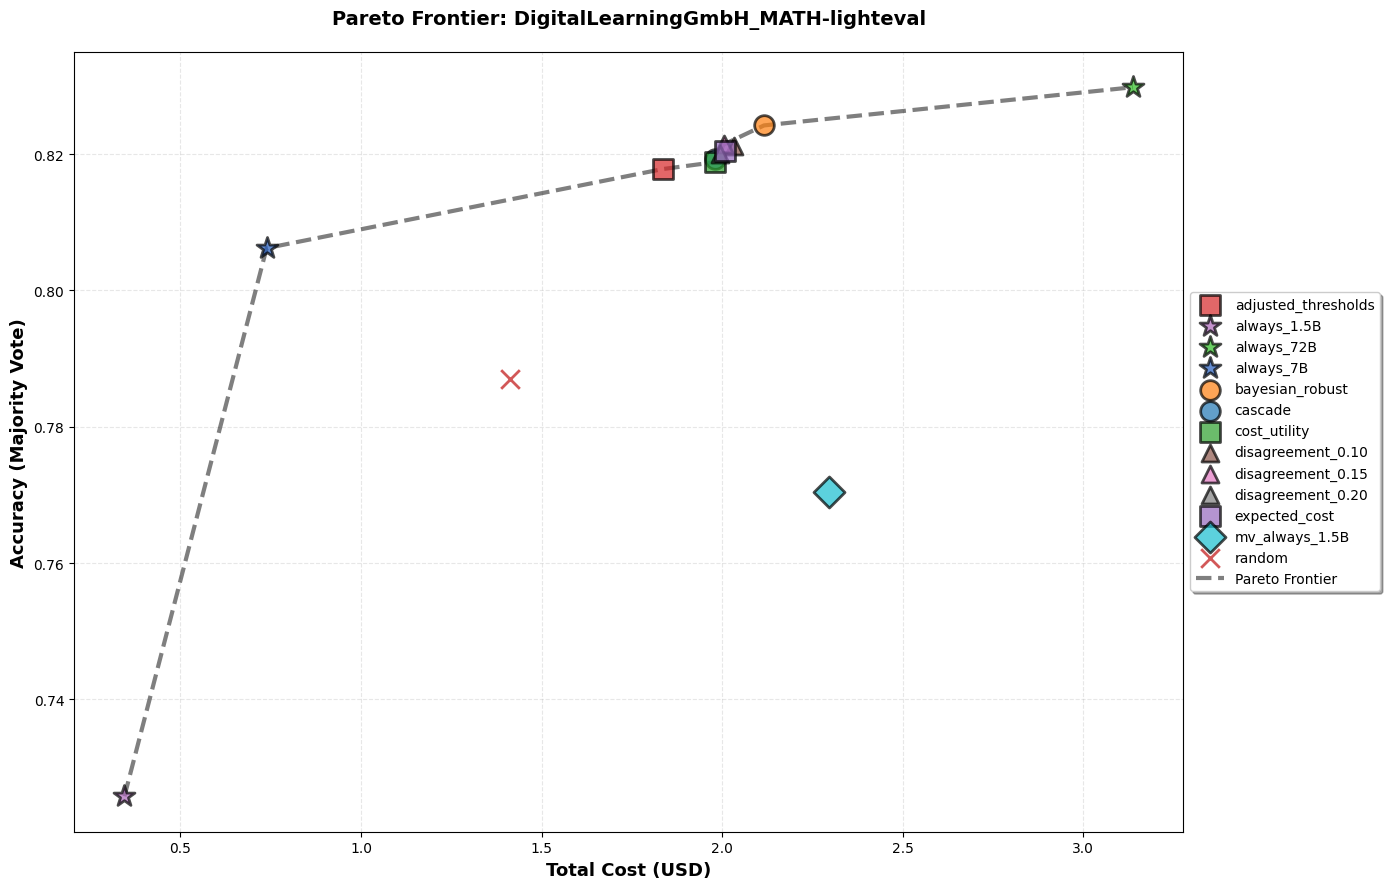


opencompass_AIME2025:
--------------------------------------------------------------------------------
  ✓ random                                   Acc=0.0667 | Cost=$0.0114
  ✓ always_72B                               Acc=0.1333 | Cost=$0.0182
  ✓ always_7B                                Acc=0.1333 | Cost=$0.0040
  ✓ always_1.5B                              Acc=0.0667 | Cost=$0.0016
  ✓ cascade                                  Acc=0.1333 | Cost=$0.0182
  ✓ bayesian_robust                          Acc=0.1333 | Cost=$0.0182
  ✓ cost_utility                             Acc=0.1333 | Cost=$0.0182
  ✓ adjusted_thresholds                      Acc=0.1333 | Cost=$0.0182
  ✓ expected_cost                            Acc=0.1333 | Cost=$0.0182
  ✓ disagreement_0.10                        Acc=0.1333 | Cost=$0.0182
  ✓ disagreement_0.15                        Acc=0.1333 | Cost=$0.0182
  ✓ disagreement_0.20                        Acc=0.1333 | Cost=$0.0182
  ✓ mv_always_1.5B                          

/tmp/ipykernel_1550202/1262369503.py:76: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(result['cost'], result['accuracy'],


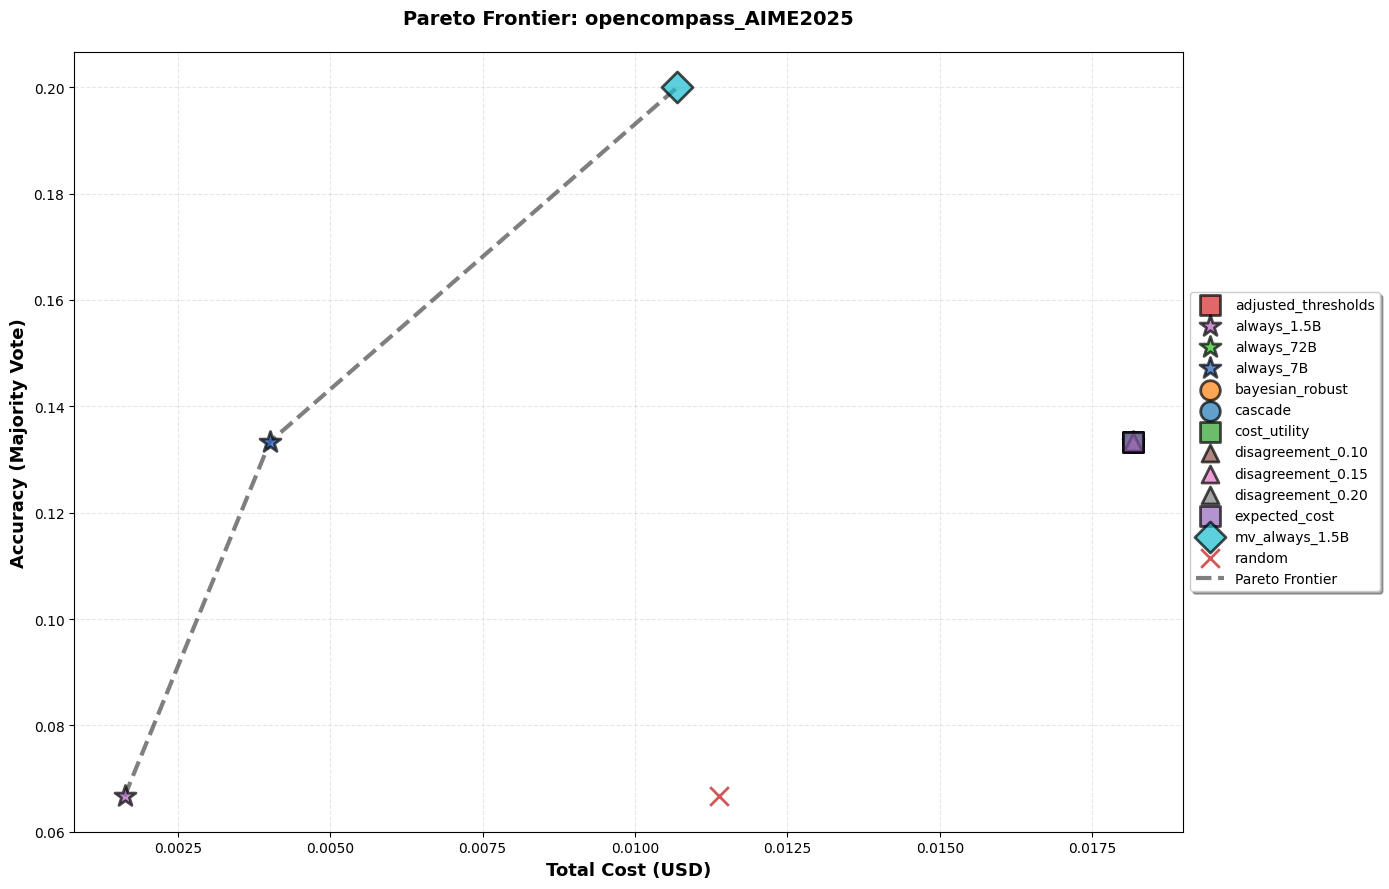


✅ Individual Pareto curves generated for all datasets


In [7]:
# === INDIVIDUAL PARETO CURVES FOR EACH DATASET ===
# Generate large, detailed Pareto frontier plots for each dataset separately

print("\n" + "="*80)
print("DETAILED PARETO CURVES - INDIVIDUAL DATASETS")
print("="*80)

PROBING_DATASET = "DigitalLearningGmbH_MATH-lighteval"
RESULTS_BASE_DIR = "../../pika_cascade_trial"
TARGET_CONF = 0.90

DATASETS = [
    "openai_gsm8k",
    "gneubig_aime-1983-2024", 
    "DigitalLearningGmbH_MATH-lighteval",
    "opencompass_AIME2025"
]

# Color and marker scheme for strategies
strategy_styles = {
    'random': {'color': "#C01111", 'marker': 'x', 'size': 180},
    'always_72B': {'color': "#2cbd22", 'marker': '*', 'size': 250},
    'always_7B': {'color': "#225bbd", 'marker': '*', 'size': 250},
    'always_1.5B': {'color': "#ab66b9", 'marker': '*', 'size': 250},
    'cascade': {'color': '#1f77b4', 'marker': 'o', 'size': 200},
    'bayesian_robust': {'color': '#ff7f0e', 'marker': 'o', 'size': 200},
    'cost_utility': {'color': '#2ca02c', 'marker': 's', 'size': 200},
    'adjusted_thresholds': {'color': '#d62728', 'marker': 's', 'size': 200},
    'expected_cost': {'color': '#9467bd', 'marker': 's', 'size': 200},
    'disagreement_0.10': {'color': '#8c564b', 'marker': '^', 'size': 150},
    'disagreement_0.15': {'color': '#e377c2', 'marker': '^', 'size': 150},
    'disagreement_0.20': {'color': '#7f7f7f', 'marker': '^', 'size': 150},
    'mv_always_1.5B': {'color': '#17becf', 'marker': 'D', 'size': 250},
    # 'mv_always_7B': {'color': '#bcbd22', 'marker': 'D', 'size': 250},
    # 'mv_always_72B': {'color': "#bd2282", 'marker': 'D', 'size': 250},
    # 'mv_adaptive_escalation_tight': {'color': '#ff9896', 'marker': 'P', 'size': 250},
    # 'mv_adaptive_escalation_loose': {'color': '#98df8a', 'marker': 'P', 'size': 250},
}

for dataset in DATASETS:
    print(f"\n{dataset}:")
    print("-" * 80)
    
    dataset_results = {}
    
    # Load all strategy results for this dataset
    for strategy_name, style in strategy_styles.items():
        try:
            result_path = f"{RESULTS_BASE_DIR}/{PROBING_DATASET}_probe/{dataset}_routed/answered_{strategy_name}_conf{TARGET_CONF}.parquet"
            strategy_df = pd.read_parquet(result_path)
            
            accuracy = strategy_df["majority_vote_is_correct"].mean()
            cost = strategy_df["total_cost_usd"].sum()
            
            dataset_results[strategy_name] = {
                'accuracy': accuracy,
                'cost': cost,
                'n_samples': len(strategy_df)
            }
            
            print(f"  ✓ {strategy_name:<40} Acc={accuracy:.4f} | Cost=${cost:.4f}")
            
        except FileNotFoundError:
            pass
        except Exception as e:
            pass
    
    # Create individual plot for this dataset
    if dataset_results:
        fig, ax = plt.subplots(figsize=(14, 9))
        
        # Plot each strategy
        for strategy_name, result in sorted(dataset_results.items()):
            style = strategy_styles.get(strategy_name, {'color': 'gray', 'marker': 'o', 'size': 150})
            
            ax.scatter(result['cost'], result['accuracy'],
                      s=style['size'], alpha=0.7, c=style['color'], marker=style['marker'],
                      edgecolor='black', linewidth=2, label=strategy_name, zorder=3)
        
        # Calculate and plot Pareto frontier
        if len(dataset_results) > 1:
            sorted_by_cost = sorted(dataset_results.items(), key=lambda x: x[1]['cost'])
            frontier_x = []
            frontier_y = []
            frontier_strategies = []
            max_acc = 0
            
            for strategy_name, result in sorted_by_cost:
                if result['accuracy'] >= max_acc:
                    frontier_x.append(result['cost'])
                    frontier_y.append(result['accuracy'])
                    frontier_strategies.append(strategy_name)
                    max_acc = result['accuracy']
            
            if len(frontier_x) > 1:
                ax.plot(frontier_x, frontier_y, 'k--', linewidth=3, alpha=0.5, label='Pareto Frontier', zorder=2)
                
                # Highlight Pareto frontier points
                # ax.scatter(frontier_x, frontier_y, s=100, c='none', edgecolor='black', linewidth=3, zorder=4)
        
        ax.set_xlabel('Total Cost (USD)', fontsize=13, fontweight='bold')
        ax.set_ylabel('Accuracy (Majority Vote)', fontsize=13, fontweight='bold')
        ax.set_title(f'Pareto Frontier: {dataset}', fontsize=14, fontweight='bold', pad=20)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_axisbelow(True)
        
        # Legend outside plot area
        ax.legend(fontsize=10, loc='center left', bbox_to_anchor=(1.0, 0.5),
                 frameon=True, fancybox=True, shadow=True)
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"  ⚠️ No results found for {dataset}")

print("\n" + "="*80)
print("✅ Individual Pareto curves generated for all datasets")
print("="*80)



DETAILED PARETO CURVES - INDIVIDUAL DATASETS

openai_gsm8k:
--------------------------------------------------------------------------------
  ✓ cascade                                  Acc=0.9196 | Cost=$0.2821
  ✓ bayesian_robust                          Acc=0.9416 | Cost=$0.4345
  ✓ cost_utility                             Acc=0.9181 | Cost=$0.2822
  ✓ adjusted_thresholds                      Acc=0.9189 | Cost=$0.2595
  ✓ expected_cost                            Acc=0.9174 | Cost=$0.2824
  ✓ disagreement_0.10                        Acc=0.9265 | Cost=$0.3629
  ✓ disagreement_0.15                        Acc=0.9234 | Cost=$0.3062
  ✓ disagreement_0.20                        Acc=0.9189 | Cost=$0.2900


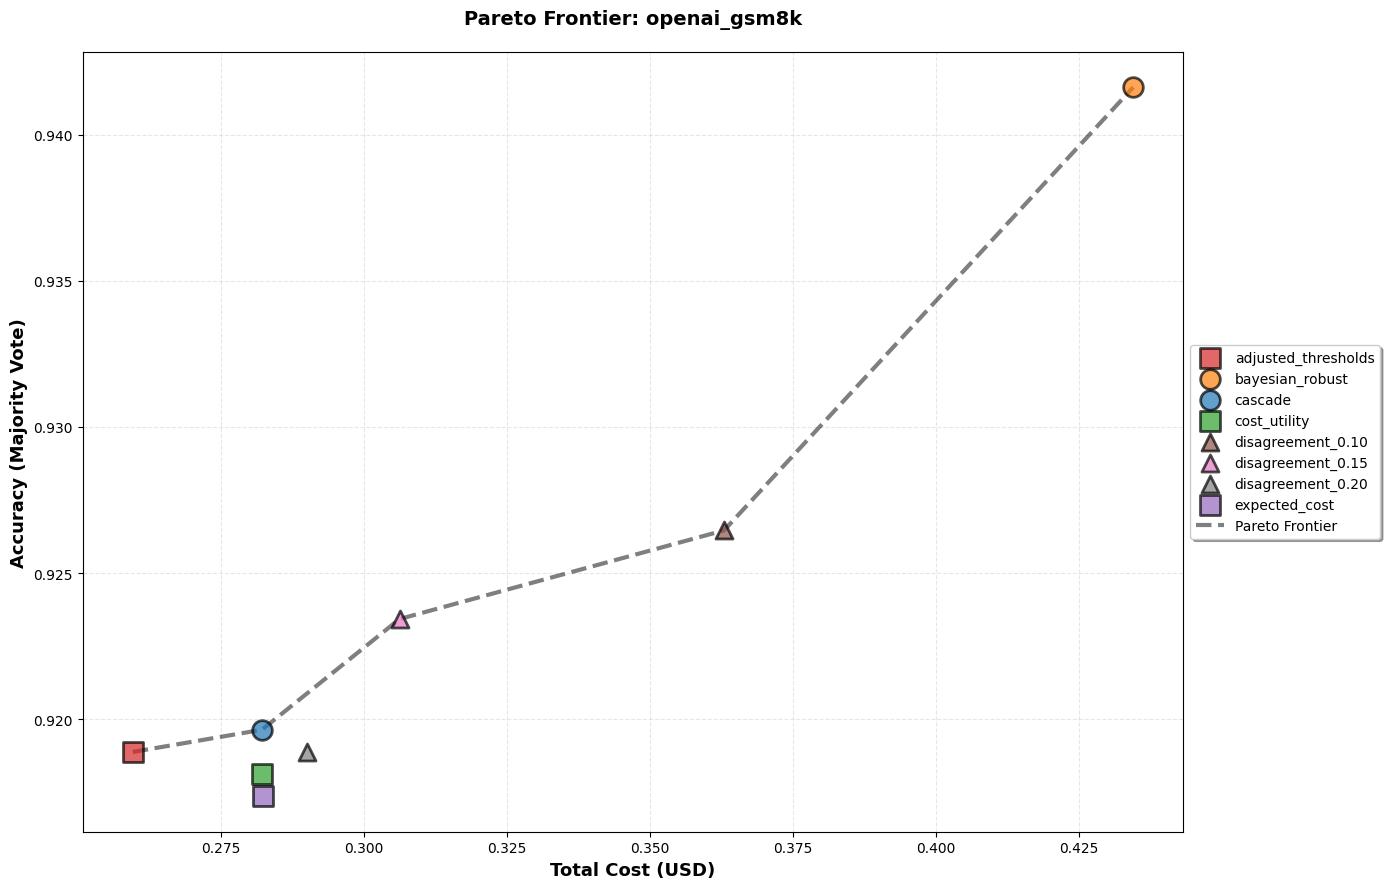


gneubig_aime-1983-2024:
--------------------------------------------------------------------------------
  ✓ cascade                                  Acc=0.3633 | Cost=$1.0223
  ✓ bayesian_robust                          Acc=0.3644 | Cost=$1.0279
  ✓ cost_utility                             Acc=0.3633 | Cost=$1.0231
  ✓ adjusted_thresholds                      Acc=0.3612 | Cost=$1.0221
  ✓ expected_cost                            Acc=0.3623 | Cost=$1.0282
  ✓ disagreement_0.10                        Acc=0.3601 | Cost=$1.0326
  ✓ disagreement_0.15                        Acc=0.3601 | Cost=$1.0217
  ✓ disagreement_0.20                        Acc=0.3633 | Cost=$1.0258


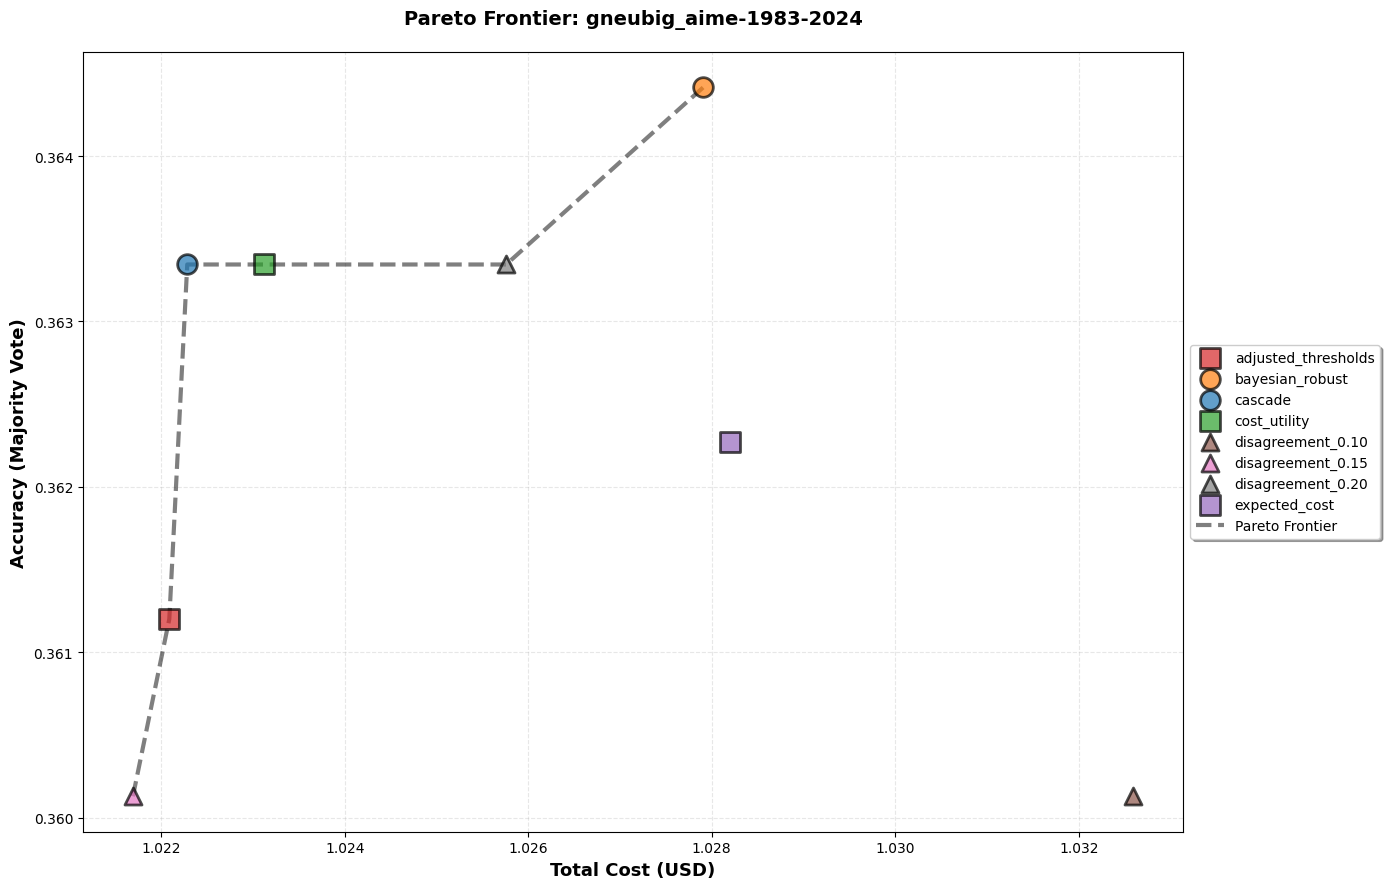


DigitalLearningGmbH_MATH-lighteval:
--------------------------------------------------------------------------------
  ⚠️ No results found for DigitalLearningGmbH_MATH-lighteval

opencompass_AIME2025:
--------------------------------------------------------------------------------
  ✓ cascade                                  Acc=0.1333 | Cost=$0.0182
  ✓ bayesian_robust                          Acc=0.1333 | Cost=$0.0182
  ✓ cost_utility                             Acc=0.1333 | Cost=$0.0182
  ✓ adjusted_thresholds                      Acc=0.1333 | Cost=$0.0182
  ✓ expected_cost                            Acc=0.1333 | Cost=$0.0182
  ✓ disagreement_0.10                        Acc=0.1333 | Cost=$0.0182
  ✓ disagreement_0.15                        Acc=0.1333 | Cost=$0.0182
  ✓ disagreement_0.20                        Acc=0.1333 | Cost=$0.0182


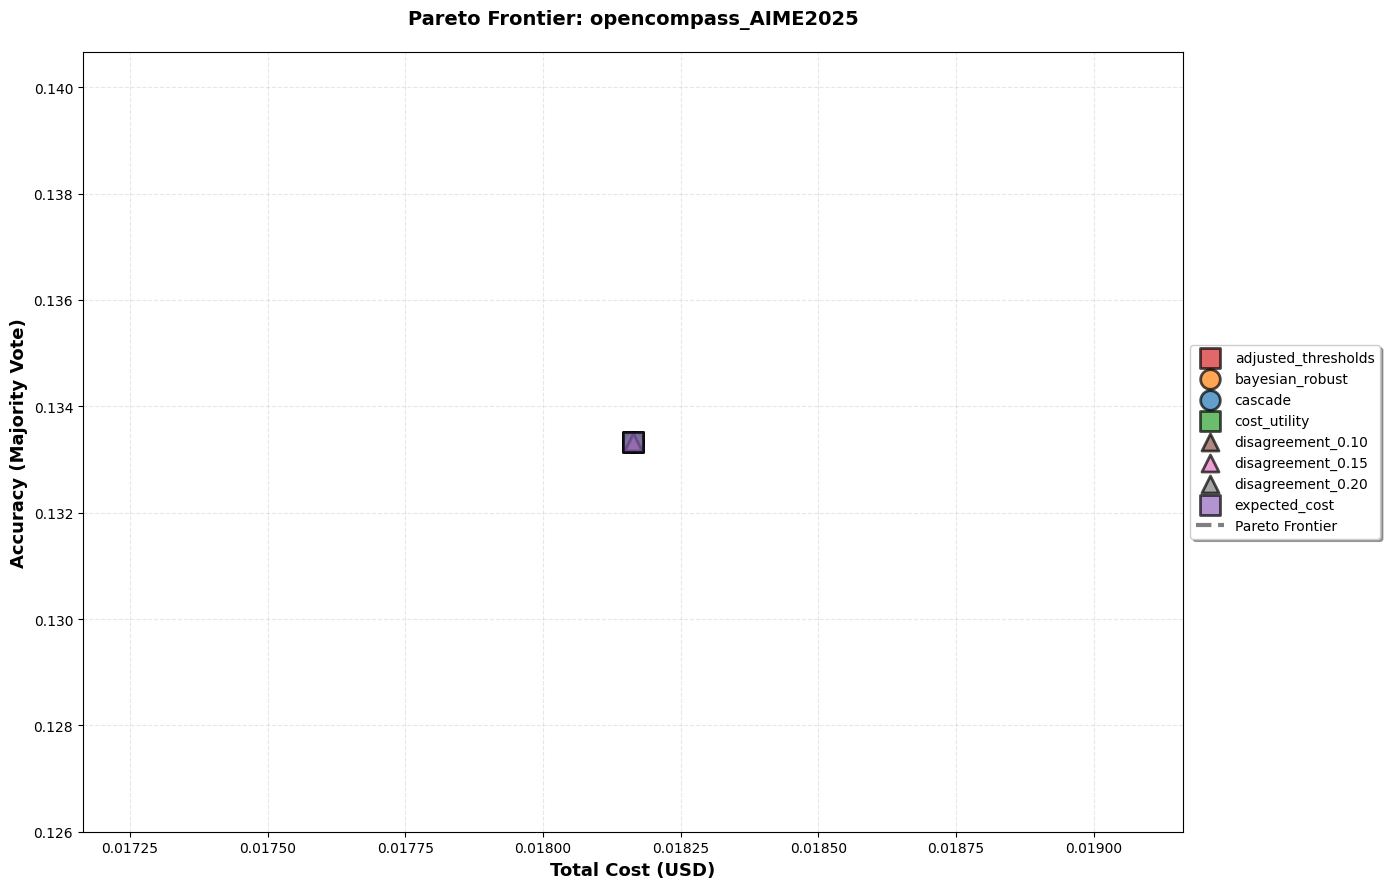


✅ Individual Pareto curves generated for all datasets


In [2]:
# === INDIVIDUAL PARETO CURVES FOR EACH DATASET ===
# Generate large, detailed Pareto frontier plots for each dataset separately

print("\n" + "="*80)
print("DETAILED PARETO CURVES - INDIVIDUAL DATASETS")
print("="*80)

PROBING_DATASET = "gneubig_aime-1983-2024"
RESULTS_BASE_DIR = "../../pika_cascade_trial"
TARGET_CONF = 0.90

DATASETS = [
    "openai_gsm8k",
    "gneubig_aime-1983-2024", 
    "DigitalLearningGmbH_MATH-lighteval",
    "opencompass_AIME2025"
]

# Color and marker scheme for strategies
strategy_styles = {
    'random': {'color': "#C01111", 'marker': 'x', 'size': 180},
    'always_72B': {'color': "#2cbd22", 'marker': '*', 'size': 250},
    'always_7B': {'color': "#225bbd", 'marker': '*', 'size': 250},
    'always_1.5B': {'color': "#ab66b9", 'marker': '*', 'size': 250},
    'cascade': {'color': '#1f77b4', 'marker': 'o', 'size': 200},
    'bayesian_robust': {'color': '#ff7f0e', 'marker': 'o', 'size': 200},
    'cost_utility': {'color': '#2ca02c', 'marker': 's', 'size': 200},
    'adjusted_thresholds': {'color': '#d62728', 'marker': 's', 'size': 200},
    'expected_cost': {'color': '#9467bd', 'marker': 's', 'size': 200},
    'disagreement_0.10': {'color': '#8c564b', 'marker': '^', 'size': 150},
    'disagreement_0.15': {'color': '#e377c2', 'marker': '^', 'size': 150},
    'disagreement_0.20': {'color': '#7f7f7f', 'marker': '^', 'size': 150},
    # 'mv_always_1.5B': {'color': '#17becf', 'marker': 'D', 'size': 250},
    # 'mv_always_7B': {'color': '#bcbd22', 'marker': 'D', 'size': 250},
    # 'mv_always_72B': {'color': "#bd2282", 'marker': 'D', 'size': 250},
    # 'mv_adaptive_escalation_tight': {'color': '#ff9896', 'marker': 'P', 'size': 250},
    # 'mv_adaptive_escalation_loose': {'color': '#98df8a', 'marker': 'P', 'size': 250},
}

for dataset in DATASETS:
    print(f"\n{dataset}:")
    print("-" * 80)
    
    dataset_results = {}
    
    # Load all strategy results for this dataset
    for strategy_name, style in strategy_styles.items():
        try:
            result_path = f"{RESULTS_BASE_DIR}/{PROBING_DATASET}_probe/{dataset}_routed/answered_{strategy_name}_conf{TARGET_CONF}.parquet"
            strategy_df = pd.read_parquet(result_path)
            
            accuracy = strategy_df["majority_vote_is_correct"].mean()
            cost = strategy_df["total_cost_usd"].sum()
            
            dataset_results[strategy_name] = {
                'accuracy': accuracy,
                'cost': cost,
                'n_samples': len(strategy_df)
            }
            
            print(f"  ✓ {strategy_name:<40} Acc={accuracy:.4f} | Cost=${cost:.4f}")
            
        except FileNotFoundError:
            pass
        except Exception as e:
            pass
    
    # Create individual plot for this dataset
    if dataset_results:
        fig, ax = plt.subplots(figsize=(14, 9))
        
        # Plot each strategy
        for strategy_name, result in sorted(dataset_results.items()):
            style = strategy_styles.get(strategy_name, {'color': 'gray', 'marker': 'o', 'size': 150})
            
            ax.scatter(result['cost'], result['accuracy'],
                      s=style['size'], alpha=0.7, c=style['color'], marker=style['marker'],
                      edgecolor='black', linewidth=2, label=strategy_name, zorder=3)
        
        # Calculate and plot Pareto frontier
        if len(dataset_results) > 1:
            sorted_by_cost = sorted(dataset_results.items(), key=lambda x: x[1]['cost'])
            frontier_x = []
            frontier_y = []
            frontier_strategies = []
            max_acc = 0
            
            for strategy_name, result in sorted_by_cost:
                if result['accuracy'] >= max_acc:
                    frontier_x.append(result['cost'])
                    frontier_y.append(result['accuracy'])
                    frontier_strategies.append(strategy_name)
                    max_acc = result['accuracy']
            
            if len(frontier_x) > 1:
                ax.plot(frontier_x, frontier_y, 'k--', linewidth=3, alpha=0.5, label='Pareto Frontier', zorder=2)
                
                # Highlight Pareto frontier points
                # ax.scatter(frontier_x, frontier_y, s=100, c='none', edgecolor='black', linewidth=3, zorder=4)
        
        ax.set_xlabel('Total Cost (USD)', fontsize=13, fontweight='bold')
        ax.set_ylabel('Accuracy (Majority Vote)', fontsize=13, fontweight='bold')
        ax.set_title(f'Pareto Frontier: {dataset}', fontsize=14, fontweight='bold', pad=20)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_axisbelow(True)
        
        # Legend outside plot area
        ax.legend(fontsize=10, loc='center left', bbox_to_anchor=(1.0, 0.5),
                 frameon=True, fancybox=True, shadow=True)
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"  ⚠️ No results found for {dataset}")

print("\n" + "="*80)
print("✅ Individual Pareto curves generated for all datasets")
print("="*80)
